## Funding Feature Prediction Model

### General Setup and Loading Dataset


In [3]:
# Set up
import pandas as pd
import numpy as np
import joblib

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../../Datasets/Funding_DisasterDeclarationSummariesPlusLocation_RowColFiltered.csv')
print(df.head())

           incidentBeginDate           incidentEndDate           X          Y  \
0  1956-04-24 00:00:00+00:00  1956-04-24T00:00:00.000Z  -97.540981  35.470449   
1  1956-05-21 00:00:00+00:00  1956-05-21T00:00:00.000Z  -75.130236  39.998490   
2  1956-07-20 00:00:00+00:00  1956-07-20T00:00:00.000Z -122.896213  45.532320   
3  1956-08-09 00:00:00+00:00  1956-08-09T00:00:00.000Z  -75.130236  39.998490   
4  1958-04-04 00:00:00+00:00  1958-04-04T00:00:00.000Z -119.259146  35.496537   

           declarationTitle  incidentId  ihProgramDeclared  iaProgramDeclared  \
0              SEVERE STORM       56009                  0                  1   
1              SEVERE STORM       56015                  0                  1   
2             STORM & FLOOD       56012                  0                  1   
3                     STORM       56016                  0                  1   
4  HEAVY RAINSTORMS & FLOOD       58012                  0                  1   

   paProgramDeclared  hmPr

In [4]:
### --- Further data set cleaning (removing incorrectly entered columns) --- ###
# convert to datetime
df['incidentBeginDate'] = df['incidentBeginDate'].str.strip()
df['incidentBeginDate'] = pd.to_datetime(df['incidentBeginDate'], errors='coerce')
df['incidentEndDate'] = df['incidentEndDate'].str.strip()
df['incidentEndDate'] = pd.to_datetime(df['incidentEndDate'], errors='coerce')

# get rid of evacuation entries, only want entries where disaster actually happened
sub_df = df[~df['declarationTitle'].str.endswith('EVACUATION', na=False)]
sub_df = sub_df[~sub_df['declarationTitle'].str.endswith('EVACUEES', na=False)]

# Exclude data points from Idaho in 2005
sub_df = sub_df[~((sub_df['incidentBeginDate'].dt.year == 2005) &
                (sub_df['Y'] >= 41.9880) & (sub_df['Y'] <= 49.0030) &  # Latitude range of Idaho
                (sub_df['X'] >= -117.2437) & (sub_df['X'] <= -111.0430))]  # Longitude range of Idaho

### Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
Index: 47046 entries, 0 to 49767
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   incidentBeginDate                 47046 non-null  datetime64[ns, UTC]
 1   incidentEndDate                   47046 non-null  datetime64[ns, UTC]
 2   X                                 47046 non-null  float64            
 3   Y                                 47046 non-null  float64            
 4   declarationTitle                  47046 non-null  object             
 5   incidentId                        47046 non-null  int64              
 6   ihProgramDeclared                 47046 non-null  int64              
 7   iaProgramDeclared                 47046 non-null  int64              
 8   paProgramDeclared                 47046 non-null  int64              
 9   hmProgramDeclared                 47046 non-null  int64           

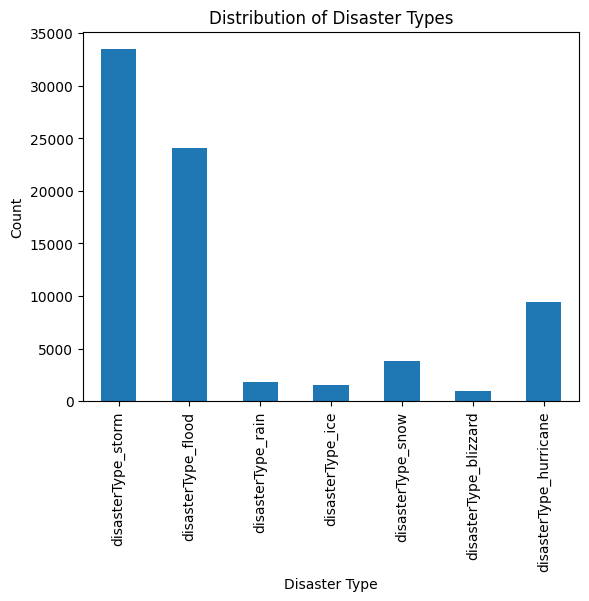

In [5]:
# --- Basic Data Exploration --- #
df = sub_df.copy()
df.info()

# Display basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Display the distribution of disaster types
disaster_type_counts = df[['disasterType_storm', 'disasterType_flood', 'disasterType_rain', 'disasterType_ice', 'disasterType_snow', 'disasterType_blizzard', 'disasterType_hurricane']].sum()
print(disaster_type_counts)

# Plot the distribution of disaster types
disaster_type_counts.plot(kind='bar')
plt.title('Distribution of Disaster Types')
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.show()


ihProgramDeclared     6564
iaProgramDeclared    14961
paProgramDeclared    43500
hmProgramDeclared    22976
dtype: int64


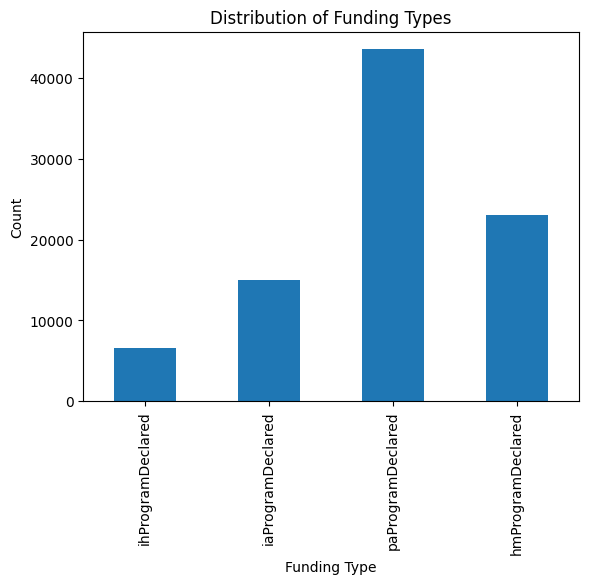

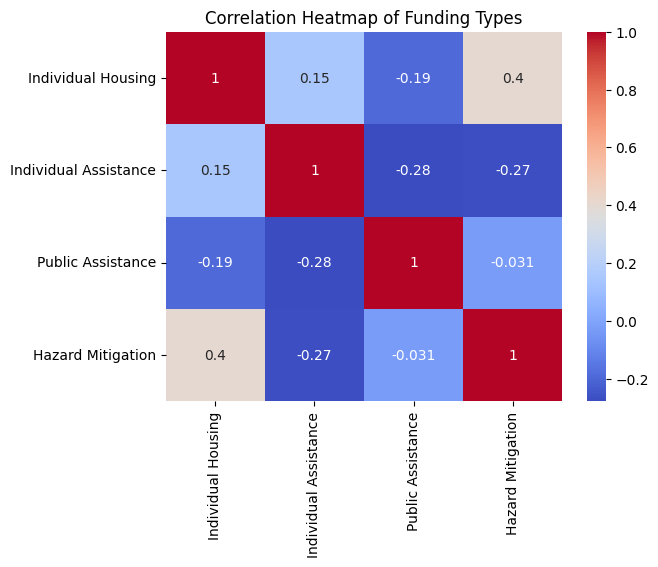

In [6]:
# Display the distribution of funding types
funding_type_counts = df[['ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared']].sum()
print(funding_type_counts)

# Plot the distribution of funding types
funding_type_counts.plot(kind='bar')
plt.title('Distribution of Funding Types')
plt.xlabel('Funding Type')
plt.ylabel('Count')
plt.show()

# Create a heatmap to show how these funding types are combined
funding_combinations = df[['ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared']].corr()

# Change the x and y axis values to be the actual names of the programs
ax = sns.heatmap(funding_combinations, annot=True, cmap='coolwarm', cbar=True)
ax.set_xticklabels(['Individual Housing', 'Individual Assistance', 'Public Assistance', 'Hazard Mitigation'])
ax.set_yticklabels(['Individual Housing', 'Individual Assistance', 'Public Assistance', 'Hazard Mitigation'])
plt.title('Correlation Heatmap of Funding Types')
plt.show()

   Principal Component 1  Principal Component 2  ihProgramDeclared  \
0              -3.098091              -2.295502                  0   
1              -3.093213              -2.291858                  0   
2              -3.845893              -1.623219                  0   
3              -3.078758              -2.281059                  0   
4              -4.753679              -2.878082                  0   

   iaProgramDeclared  paProgramDeclared  hmProgramDeclared  
0                  1                  1                  1  
1                  1                  1                  1  
2                  1                  1                  1  
3                  1                  1                  1  
4                  1                  1                  1  


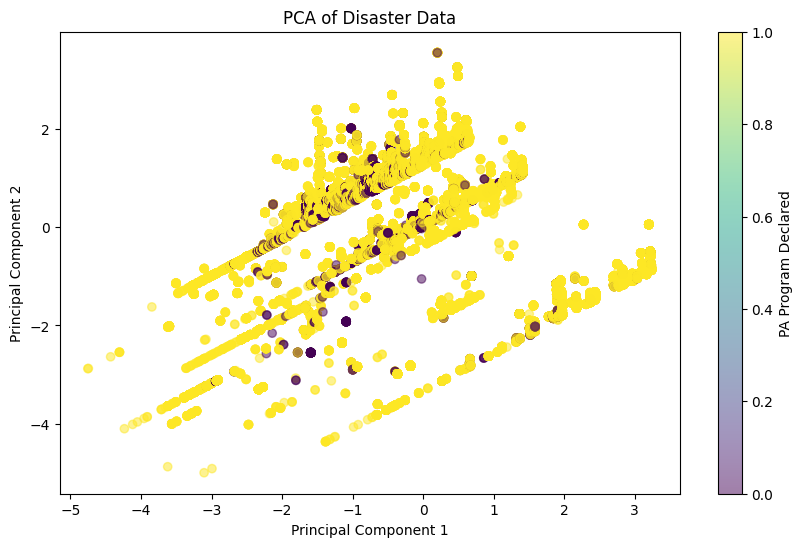

In [7]:
from sklearn.decomposition import PCA

# Select features for PCA
features = df[['incidentDurationInDays', 'timeOfStartInDays', 'timeOfEndInDays', 'disasterType_storm', 'disasterType_flood', 'disasterType_rain', 'disasterType_ice', 'disasterType_snow', 'disasterType_blizzard', 'disasterType_hurricane']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Add funding types to the PCA DataFrame
pca_df = pd.concat([pca_df, df[['ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared']].reset_index(drop=True)], axis=1)

print(pca_df.head())

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=df['paProgramDeclared'], cmap='viridis', alpha=0.5)
plt.colorbar(label='PA Program Declared')
plt.title('PCA of Disaster Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [8]:
# Collect relevant features
categorical_features = ['state', 'declarationType', 'incidentType']
features_with_date = ['declarationDate', 'incidentBeginDate', 'incidentEndDate']
features = ['disasterNumber', 'fyDeclared',
            'incidentEndDate', 'region', 'fipsStateCode', 'fipsCountyCode']

# targets
targets = ['ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared']

=== Basic Statistics ===
       ihProgramDeclared  iaProgramDeclared  paProgramDeclared  \
count       47046.000000       47046.000000       47046.000000   
mean            0.139523           0.318008           0.924627   
std             0.346495           0.465708           0.263995   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           1.000000   
50%             0.000000           0.000000           1.000000   
75%             0.000000           1.000000           1.000000   
max             1.000000           1.000000           1.000000   

       hmProgramDeclared  
count       47046.000000  
mean            0.488373  
std             0.499870  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             1.000000  
max             1.000000  
count    47046.000000
mean         5.165306
std          1.892742
min          1.000000
25%          4.000000
50%          5.000000
75%  

/var/folders/6k/yg9y73qs2hz37v5r2l39pt0m0000gn/T/ipykernel_6100/3938178433.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
/var/folders/6k/yg9y73qs2hz37v5r2l39pt0m0000gn/T/ipykernel_6100/3938178433.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
/var/folders/6k/yg9y73qs2hz37v5r2l39pt0m0000gn/T/ipykernel_6100/3938178433.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
/var/folders/6k/yg9y73qs2hz37v5r2l39pt0m0000gn/T/ipykernel_6100/3938178433.py:30: UserWarning: set_ticklabels() should only be use

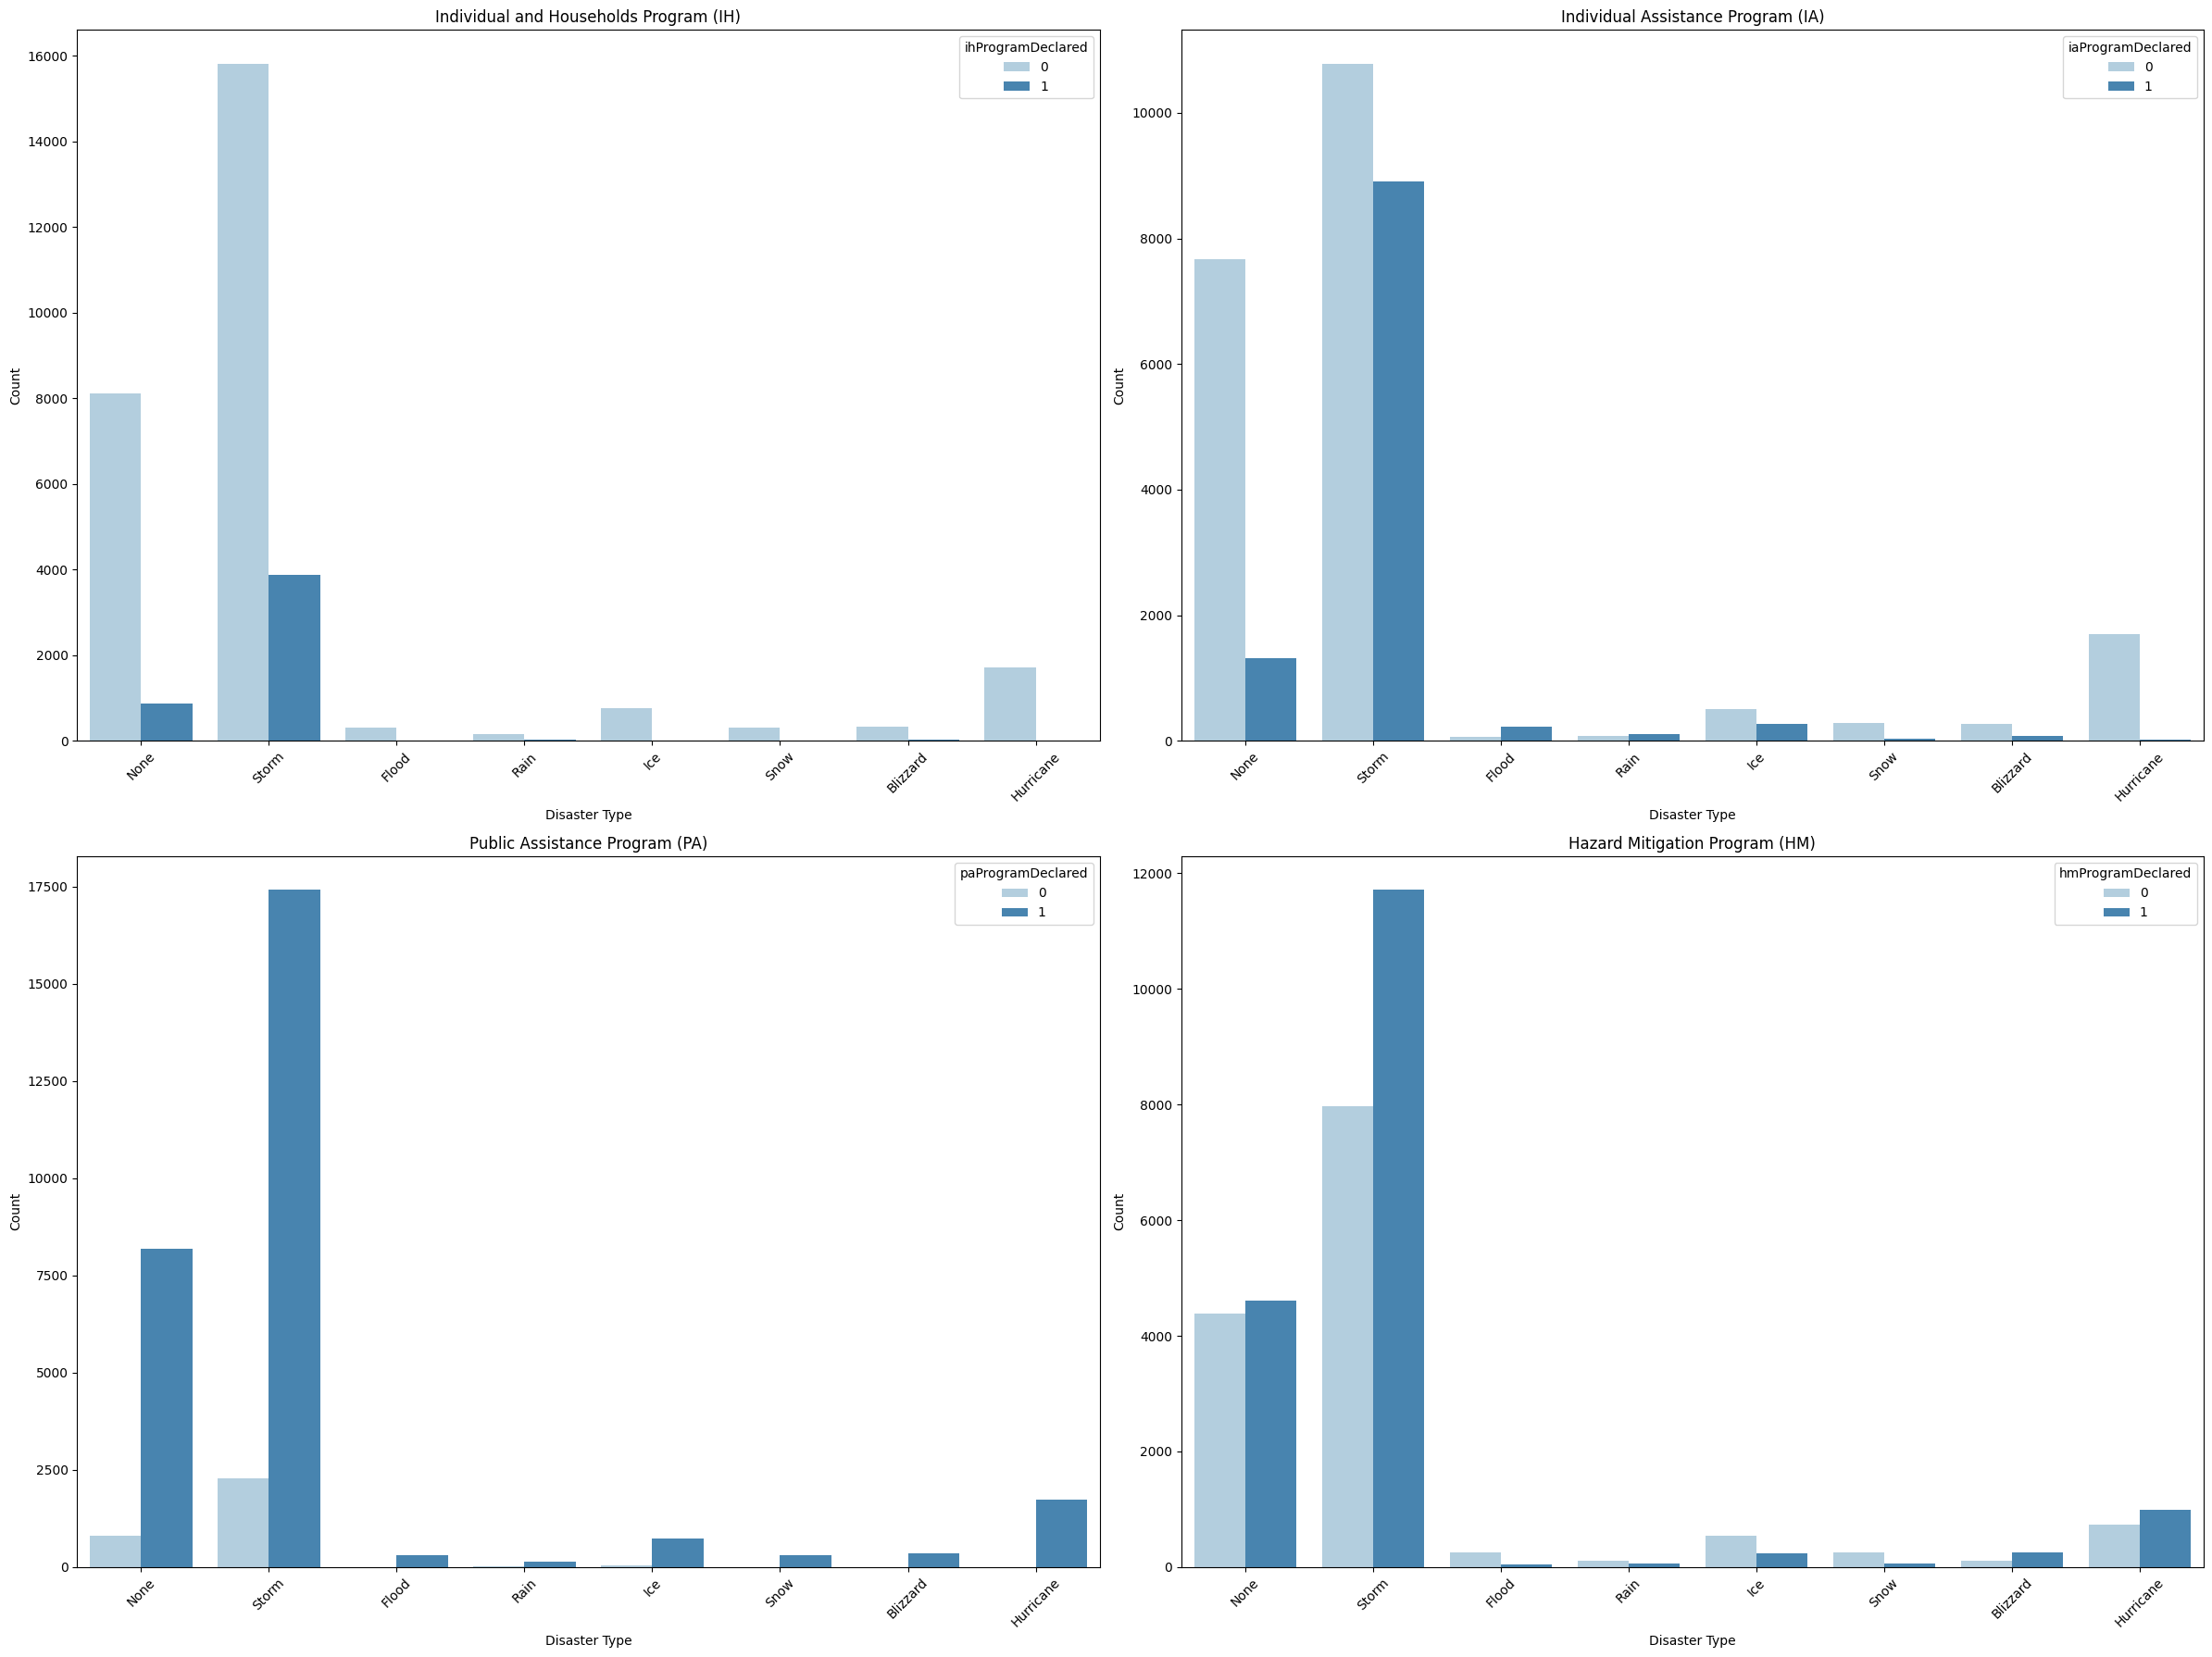

In [9]:
# Create a mapping for disaster type categorical encoding
disaster_type_mapping = {
    0.0: 'None',
    1.0: 'Storm',
    2.0: 'Flood',
    3.0: 'Rain',
    4.0: 'Ice',
    5.0: 'Snow',
    6.0: 'Blizzard',
    7.0: 'Hurricane'
}

# Map the disaster type categorical encoding to their names
df['disasterType'] = df['disasterType_categoricalEncoding'].map(disaster_type_mapping)

# Exploratory Data Analysis for Funding Features
print("=== Basic Statistics ===")
print(df[targets].describe())
print(df['region'].describe())

fig, axes = plt.subplots(2, 2, figsize=(24, 18))

titles = ['Individual and Households Program (IH)', 'Individual Assistance Program (IA)', 'Public Assistance Program (PA)', 'Hazard Mitigation Program (HM)']
targets = ['ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared']

for i, (program, title) in enumerate(zip(targets, titles)):
    row, col = divmod(i, 2)
    sns.countplot(data=df, x='disasterType', hue=program, ax=axes[row, col], palette="Blues")
    axes[row, col].set_title(title)
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
    axes[row, col].set_xlabel('Disaster Type')
    axes[row, col].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Preprocessing Feature Data for Training

In [10]:
# --- Data Preprocessing --- #

# Collect features
categorical_features = ['state']
features_with_date = ['incidentBeginDate']
features = ['fyDeclared', 'region', 'fipsStateCode', 'fipsCountyCode', 'disasterType_categoricalEncoding']

# Extract month data from incidentBeginDate (month is categorical feature)
df['incidentMonth'] = pd.to_datetime(df['incidentBeginDate']).dt.month
categorical_features.append('incidentMonth')

# Convert date to time since first event
df['incidentBeginDate'] = pd.to_datetime(df['incidentBeginDate'])
df['incidentBeginDate'] = (df['incidentBeginDate'] - df['incidentBeginDate'].min()).dt.days

# One hot encode relevant features (states, month)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))

# Combine features and extract targets
df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)
X = pd.concat([df[features], df[features_with_date], encoded_df], axis=1)
y = df[targets]
print(X.head())
print(y.head())

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Combine features and extract targets
X = pd.concat([df[features], df[features_with_date], encoded_df], axis=1)
y = df[targets]
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)

   fyDeclared  region  fipsStateCode  fipsCountyCode  \
0        1956       4             37               0   
1        1956       3             42               0   
2        1956      10             41               0   
3        1956       3             42               0   
4        1958       9              6               0   

   disasterType_categoricalEncoding  incidentBeginDate  state_AL  state_AR  \
0                               0.0               1075       0.0       0.0   
1                               0.0               1102       0.0       0.0   
2                               1.0               1162       0.0       0.0   
3                               0.0               1182       0.0       0.0   
4                               2.0               1785       0.0       0.0   

   state_AS  state_AZ  ...  incidentMonth_3  incidentMonth_4  incidentMonth_5  \
0       0.0       0.0  ...              0.0              1.0              0.0   
1       0.0       0.0  ...      

### Training Model Approach 1: Neural Network

In [11]:
### APPROACH 1 ###
# Neural Network for Multi-Label Binary Classification (4 Outputs, each Binary)

# model for multi label classification for types of funding needed
class DisasterFundingNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DisasterFundingNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.sigmoid(self.output_layer(x))
        # used sigmoid bc multi label classification problem
        return x

# Initialize model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = DisasterFundingNN(input_dim, output_dim)

# Set up loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
batch_size = 32

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 🔹 Evaluate the model with different loss functions
loss_functions = {
    'BCEWithLogitsLoss': nn.BCEWithLogitsLoss(),
    'BCELoss': nn.BCELoss(),
    'CrossEntropyLoss': nn.CrossEntropyLoss()
}

for loss_name, loss_fn in loss_functions.items():
    # Initialize model
    model = DisasterFundingNN(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        
        if loss_name == 'CrossEntropyLoss':
            # CrossEntropyLoss expects target to be of type Long and 1D
            loss = loss_fn(outputs, y_train.argmax(dim=1).long())
        else:
            loss = loss_fn(outputs, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        
        if loss_name == 'CrossEntropyLoss':
            y_pred = outputs.argmax(dim=1)
            y_test_np = y_test.argmax(dim=1).numpy()
        else:
            y_pred = (outputs > 0.5).float()
            y_test_np = y_test.numpy()
        
        print(f"Classification Report for {loss_name}:")
        print(classification_report(y_test_np, y_pred.numpy(), target_names=['ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared']))

# 🔹 Print classification report
y_test_np = y_test.numpy()

Epoch [10/50], Loss: 0.6921
Epoch [20/50], Loss: 0.6618
Epoch [30/50], Loss: 0.6144
Epoch [40/50], Loss: 0.5493
Epoch [50/50], Loss: 0.4909
Classification Report for BCEWithLogitsLoss:
                   precision    recall  f1-score   support

ihProgramDeclared       0.00      0.00      0.00      1282
iaProgramDeclared       0.00      0.00      0.00      2994
paProgramDeclared       0.92      1.00      0.96      8669
hmProgramDeclared       0.00      0.00      0.00      4571

        micro avg       0.92      0.49      0.64     17516
        macro avg       0.23      0.25      0.24     17516
     weighted avg       0.46      0.49      0.47     17516
      samples avg       0.92      0.58      0.68     17516



/Users/manavgurnani21/2025_ECS171_FinalProject_NaturalHazardsSpatiotemporalModel/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manavgurnani21/2025_ECS171_FinalProject_NaturalHazardsSpatiotemporalModel/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for BCELoss:
                   precision    recall  f1-score   support

ihProgramDeclared       0.00      0.00      0.00      1282
iaProgramDeclared       0.00      0.00      0.00      2994
paProgramDeclared       0.92      1.00      0.96      8669
hmProgramDeclared       0.65      0.55      0.60      4571

        micro avg       0.84      0.64      0.73     17516
        macro avg       0.39      0.39      0.39     17516
     weighted avg       0.63      0.64      0.63     17516
      samples avg       0.86      0.70      0.73     17516



/Users/manavgurnani21/2025_ECS171_FinalProject_NaturalHazardsSpatiotemporalModel/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manavgurnani21/2025_ECS171_FinalProject_NaturalHazardsSpatiotemporalModel/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for CrossEntropyLoss:
                   precision    recall  f1-score   support

ihProgramDeclared       0.00      0.00      0.00      1283
iaProgramDeclared       0.00      0.00      0.00      2373
paProgramDeclared       0.60      1.00      0.75      5658
hmProgramDeclared       0.00      0.00      0.00        96

         accuracy                           0.60      9410
        macro avg       0.15      0.25      0.19      9410
     weighted avg       0.36      0.60      0.45      9410



/Users/manavgurnani21/2025_ECS171_FinalProject_NaturalHazardsSpatiotemporalModel/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manavgurnani21/2025_ECS171_FinalProject_NaturalHazardsSpatiotemporalModel/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manavgurnani21/2025_ECS171_FinalProject_NaturalHazardsSpatiotemporalModel/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bein

### Training Model Appraoch 2: Random Forest Classifier

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_classifier.fit(X_train, y_train)

# 🔹 Make predictions
y_pred = rf_classifier.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.62      0.64      1381
           1       0.91      0.91      0.91      3099
           2       0.96      0.97      0.97      8691
           3       0.88      0.89      0.89      4662

   micro avg       0.91      0.91      0.91     17833
   macro avg       0.85      0.85      0.85     17833
weighted avg       0.91      0.91      0.91     17833
 samples avg       0.93      0.94      0.92     17833



/Users/manavgurnani21/2025_ECS171_FinalProject_NaturalHazardsSpatiotemporalModel/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
from joblib import dump, load
import random

# Save the model to a file
model_filename = '../../ui_component/saved_prediction_models/rf_classifier_model.joblib'
dump(rf_classifier, model_filename)
print(f"Model saved to {model_filename}")

# Load the model from the file
loaded_rf_classifier = joblib.load(model_filename)
print("Model loaded successfully")

# Use the loaded model to make predictions for a single example
# Generate a random number from 1 to 1000
num = random.randint(1, 1000)
single_example = X_test.iloc[[num]]  # Get the example at the random index
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(single_example)
single_prediction = loaded_rf_classifier.predict(single_example)
print(f"Prediction for single example: {single_prediction}")

Model saved to ../../ui_component/saved_prediction_models/rf_classifier_model.joblib
Model loaded successfully
      fyDeclared  region  fipsStateCode  fipsCountyCode  \
7867        1994       4             13              61   

      disasterType_categoricalEncoding  incidentBeginDate  state_AL  state_AR  \
7867                               2.0              15024       0.0       0.0   

      state_AS  state_AZ  state_CA  state_CO  state_CT  state_DE  state_FL  \
7867       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

      state_GA  state_IA  state_ID  state_IL  state_IN  state_KS  state_KY  \
7867       1.0       0.0       0.0       0.0       0.0       0.0       0.0   

      state_LA  state_MA  state_MD  state_ME  state_MI  state_MN  state_MO  \
7867       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

      state_MS  state_MT  state_NC  state_ND  state_NE  state_NH  state_NJ  \
7867       0.0       0.0       0.0       0.0       0.0    

### Hyperparameter Tuning

In [14]:
# Optimizing Hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees
    'max_depth': [None, 10, 20], # Depth of each tree
    'min_samples_split': [2, 5, 10],  # Min samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Min samples at each leaf
    'bootstrap': [True, False]  # Whether to use bootstrapping
}

# Grid Search to find best hyperparameters
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
# Dataset is unbalanced, so will use f1_micro to predict 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1_micro', verbose=3, n_jobs=4)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.916 total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.917 total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.916 total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.916 total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.917 total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.916 total time=   3.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.916 total t

KeyboardInterrupt: 

In [ ]:
# Best parameters & best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Get the best model from GridSearchCV
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(X_test)

# Print classification report
print("🔹 Best Model Classification Report 🔹")
print(classification_report(y_test, y_pred))

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Score: 0.9238343311200193
🔹 Best Model Classification Report 🔹
              precision    recall  f1-score   support

           0       0.65      0.75      0.69      1356
           1       0.90      0.96      0.93      2929
           2       0.97      0.95      0.96      8709
           3       0.90      0.92      0.91      4659

   micro avg       0.91      0.93      0.92     17653
   macro avg       0.86      0.90      0.88     17653
weighted avg       0.92      0.93      0.92     17653
 samples avg       0.94      0.95      0.92     17653



/home/jovie/2025-02-24_MainCodeBase_AyushsDeliverableRev2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Finalized Model Analysis

0.7690754516471838
Confusion Matrix:
 [[ 854    1  491   12]
 [   0 2157  119    3]
 [ 442  129 5122    3]
 [   3    2    6   66]]

Precision for each class:
 [0.65742879 0.91501706 0.96334661 0.89787234]

Recall for each class:
 [0.62979351 0.91532946 0.97175336 0.90577377]

F1-score for each class:
 [0.6433145  0.91517324 0.96753173 0.90180575]


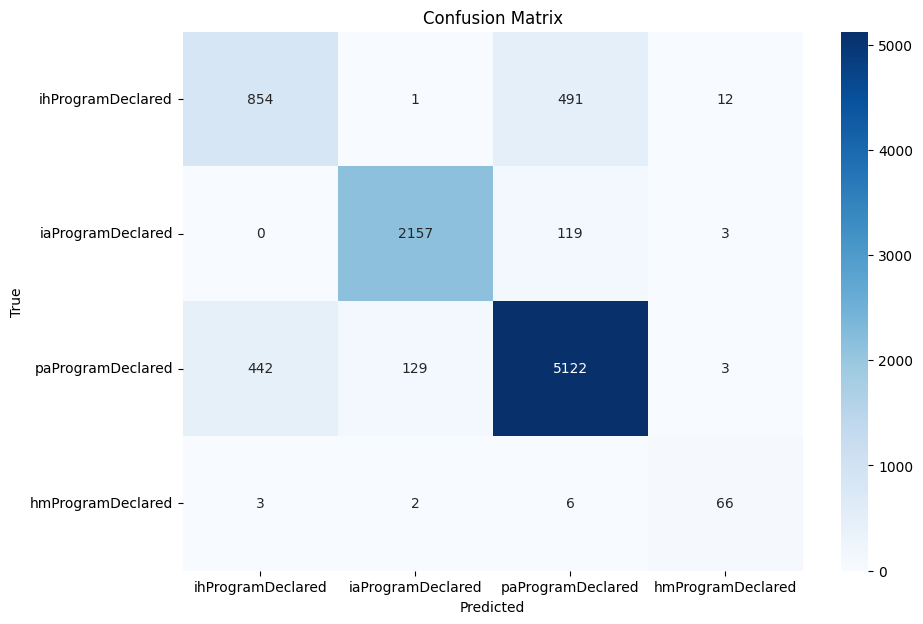

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np.argmax(axis=1), y_pred.argmax(axis=1))

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test_np, y_pred, average=None)
recall = recall_score(y_test_np, y_pred, average=None)
f1 = f1_score(y_test_np, y_pred, average=None)
accuracy = accuracy_score(y_test_np, y_pred)
print(accuracy)
# Display the results
print("Confusion Matrix:\n", conf_matrix)
print("\nPrecision for each class:\n", precision)
print("\nRecall for each class:\n", recall)
print("\nF1-score for each class:\n", f1)


# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=targets, yticklabels=targets)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

y_test_bin shape: (9410, 4)
y_pred_prob shape: (4, 9410, 2)
AUC-ROC score for class 0: 0.94
AUC-ROC score for class 1: 0.99
AUC-ROC score for class 2: 0.92
AUC-ROC score for class 3: 0.98


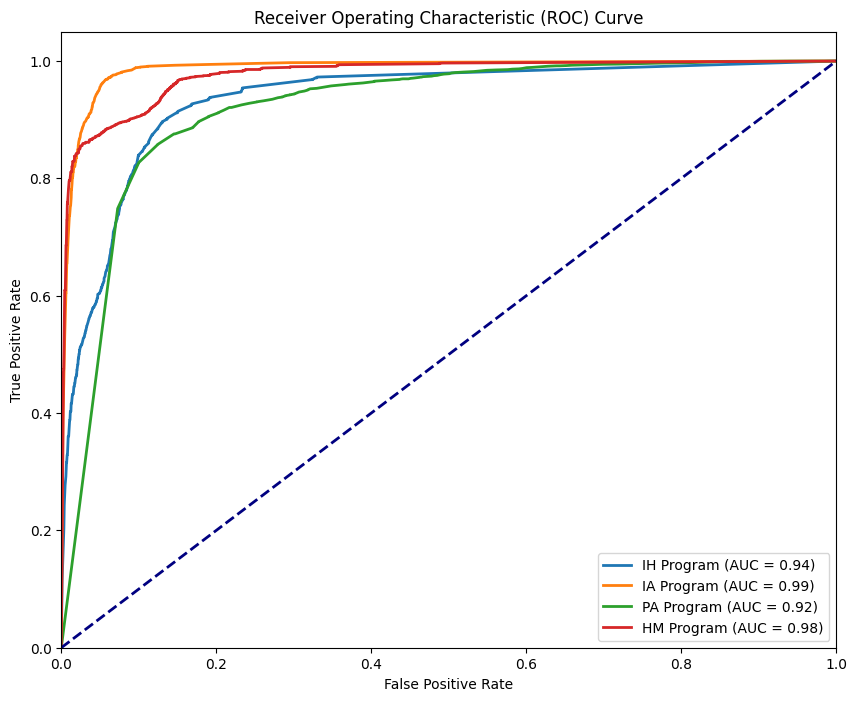

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels for multiclass classification (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_pred_prob = rf_classifier.predict_proba(X_test)

# Check the shape of y_test_bin and y_pred_prob
print("y_test_bin shape:", y_test_bin.shape)
print("y_pred_prob shape:", np.shape(y_pred_prob))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[i][:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
class_names = ['IH Program', 'IA Program', 'PA Program', 'HM Program']
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'class (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
# Calculate and print the AUC-ROC score for each class
for i in range(4):
    print(f"AUC-ROC score for class {i}: {roc_auc[i]:.2f}")

plt.show()